<a href="https://colab.research.google.com/github/cottascience/crosstalk-q1-2025/blob/main/notebooks/2_DEL_ExploratoryDataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory data analysis (EDA)

Today we'll be investigating the HitGen DEL library for the protein WDR91.

HitGen has screened a large set of compounds which are proprietary. Lucky for us they have shared fingerprints of these compounds, and we can use these to search within a catalogue of non-proprietary compounds to prioritize what to test as a potential binder of WDR91.

We'll work through the following goals:
1. Investigate the data
1. Learn about a published approach
1. Start planning your approach





# Getting started

In order to use HitGen data, we have to agree to the terms of service. Click through downloading the WDR91 dataset [here](https://aircheck.ai/datasets) to agree to these. (you don't have to download the whole dataset to agree to ToS)

⚠️**Compounds fingerprints cannot be reversed-engineered to obtain SMILES**



The [aircheck readme](https://aircheck.ai/readme) provides useful details about the DEL screening.


✏️ Make note of the following:
* How is a positive defined in a DEL screen?
* What is the class balance of all DEL datasets on aircheck?
* Look at the data dictionary. What columns might be useful to investigate?




# Our protein of interest: WDR91

WDR91 is a WD40 repeat-containing protein. Proteins in this family act as scaffolds for other proteins to stick to when forming multiprotein complexes WDR domain-containing proteins comprise one of the largest protein families in humans and are involved in a diverse array of cellular networks and diseases.

WDR91 plays a critical role in regulating early-to-late endosomal maturation and trafficking, processes essential for cellular functions such as nutrient uptake, signal transduction, and membrane protein recycling [1][2]

[1]: Schapira, Matthieu, et al. "WD40 repeat domain proteins: a novel target class?." Nature reviews Drug discovery 16.11 (2017): 773-786. ([link](https://doi.org/10.1038/nrd.2017.179))

[2]: Stirnimann, Christian U., et al. "WD40 proteins propel cellular networks." Trends in biochemical sciences 35.10 (2010): 565-574. ([link](https://doi.org/10.1016/j.tibs.2010.04.003))



✏️ Try the following:
* look it up on uniprot https://www.uniprot.org/uniprotkb/A4D1P6/entry
* where is it located in the cell? what does it do?
* what disease is disfunction of this protein associated with?


# Load the data

We've prepared a training dataset for you which will download when you run the next cell. This is a large file, so we won't load the whole thing into memory all at once.




In [1]:
# Download the file from google drive
import gdown
import os

file_id = '1iDn6HEO6oXO5lI5cQscxh_VQjpSAcGac'
train_file = 'crosstalk_train.parquet'
if not os.path.exists(train_file):
    gdown.download(id=file_id, output=train_file, quiet=False)

FileURLRetrievalError: Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1iDn6HEO6oXO5lI5cQscxh_VQjpSAcGac

but Gdown can't. Please check connections and permissions.

We'll also load some extra packages to use in our EDA

In [2]:
# package to efficiently read in data from parquet file
from pyarrow.parquet import ParquetFile
import pyarrow as pa

# packages to help us with data manipulation in tables
import pandas as pd
import numpy as np

# packages for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# package for making umaps
!pip install umap-learn
import umap


ImportError: Unable to import required dependencies:
numpy: Error importing numpy: you should not try to import numpy from
        its source directory; please exit the numpy source tree, and relaunch
        your python interpreter from there.

In [3]:
# Read data from parquet file
pf = ParquetFile(train_file)

# load all columns of the first 10 rows
first_ten_rows = next(pf.iter_batches(batch_size = 10))
train_data = pa.Table.from_batches([first_ten_rows]).to_pandas()

FileNotFoundError: [Errno 2] Failed to open local file 'crosstalk_train.parquet'. Detail: [errno 2] No such file or directory

In [4]:
train_data.head()

NameError: name 'train_data' is not defined

Take some time to explore what the different columns mean:


| Field Name   | Data Type | Mode     | Description                                                                 |
|--------------|-----------|----------|-----------------------------------------------------------------------------|
| ID           | Long      | Required | Unique computed ID from DEL_ID concatenating DEL Library ID and Building Block IDs. |
| DEL_ID       | String    | Required | Unique ID of full enumerated DNA-Encoded Library (DEL) compound.            |
| Label        | Integer   | Required | Binary classification label for observed enrichment (0 not enriched, 1 enriched). |
| RawCount     | Integer   | Nullable | The sequence count (enrichment) for the specific target.                    |
| TARGET_ID    | String    | Required | Unique ID of the target.                                                   |
| ECFP4        | Bytes     | Nullable | Count (non-binary) fingerprint generated using Extended Connectivity Fingerprint (ECFP) with radius 2 and 2048 bits. |
| ECFP6        | Bytes     | Nullable | Count (non-binary) fingerprint generated using Extended Connectivity Fingerprint (ECFP) with radius 3 and 2048 bits. |
| FCFP4        | Bytes     | Nullable | Count (non-binary) fingerprint generated using Functional Connectivity Fingerprints (FCFP) with radius 2 and 2048 bits. |
| FCFP6        | Bytes     | Nullable | Count (non-binary) fingerprint generated using Functional Connectivity Fingerprints (FCFP) with radius 3 and 2048 bits. |
| MACCS        | Bytes     | Nullable | FP generated using the Molecular Access System (MACCS).                     |
| RDK          | Bytes     | Nullable | FP generated using the RDKit fingerprint.                                  |
| AVALON       | Bytes     | Nullable | FP generated using the Avalon fingerprint.                                 |
| ATOMPAIR     | Bytes     | Nullable | FP generated using the Atom Pair fingerprint.                               |
| TOPTOR       | Bytes     | Nullable | FP generated using the Topological Torsion fingerprint.                     |
| MW           | Float     | Nullable | Molecular weight of the enumerated DEL rounded to its integer value.        |
| ALOGP        | Float     | Nullable | Calculated LogP of the enumerated DEL rounded to one decimal. Synonymous with ClogP. |



✏️ Let's check it out:
* How many compounds are in this screen?
* How many of these are enriched?


In [5]:
# load all rows of select columns
columns_to_load = ['Label', 'RawCount', 'ECFP4', 'MW', 'ALOGP']
train_data = pd.read_parquet(train_file, columns=columns_to_load)

NameError: name 'pd' is not defined

In [6]:
train_data.shape

NameError: name 'train_data' is not defined

In [7]:
train_data['Label'].sum()

NameError: name 'train_data' is not defined

# Investigate molecular properties

In [8]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot ALOGP histogram
sns.histplot(data=train_data, x="ALOGP", kde=True, bins=30, ax=axes[0])
axes[0].set_title("Distribution of ALOGP")

# Plot MW histogram
sns.histplot(data=train_data, x="MW", kde=True, bins=30, ax=axes[1])
axes[1].set_title("Distribution of Molecular Weight")

# Adjust layout
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

# Labels exploration

Enrichment has been binarized to 0 (not enriched) and 1 (enriched), but we can also look at the raw counts. Note: It is possible for inactive compounds to have non-zero raw count.

In [9]:
# Plot raw counts and label of enrichment
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5))

# Label 0 plot
sns.histplot(data=train_data[train_data['Label']==0], x="RawCount", bins=50, color='#1f77b4', ax=ax1)
ax1.set_xlim(0, 0.5)
ax1.set_title('Label 0')

# Label 1 plot
sns.histplot(data=train_data[train_data['Label']==1], x="RawCount", bins=50, color='#ff7f0e', ax=ax2)
ax2.set_title('Label 1')

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

# Class imbalance

This is a very unbalanced data set, a common thing in drug discovery

In [10]:
# Let's look at how many DEL hits there are
# Calculate the ratio of labels
label_counts = train_data['Label'].value_counts(normalize=True)

# Print the ratio of labels
print(label_counts)

NameError: name 'train_data' is not defined

## Dimensionality Reduction: PCA and UMAP

When working with high-dimensional data, such as chemical fingerprints, it's often useful to reduce the number of dimensions for visualization or analysis. Two popular techniques for this are **Principal Component Analysis (PCA)** and **Uniform Manifold Approximation and Projection (UMAP)**.

- **PCA** is a linear method that transforms the data to a new coordinate system, maximizing variance along each axis (principal component). It is fast and easy to interpret, but may not capture complex, nonlinear relationships in the data.

- **UMAP** is a nonlinear technique that preserves both local and global structure in the data. It is particularly effective at revealing clusters and patterns that PCA might miss, making it a powerful tool for visualizing complex datasets like chemical fingerprints.

In summary, PCA is useful for quick, interpretable reductions, while UMAP excels at uncovering intricate structures in high-dimensional data.

![Exploratory Data Analysis](https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F9052057%2F8cb9faa4ace2479120fe0a326aa53253%2Fcool.gif?generation=1674492678372413&alt=media)

When data exhibits non-linear relationships, UMAP is often more effective than linear methods like PCA at revealing underlying structure and clusters. UMAP can "unfold" complex manifolds in high-dimensional data, making it easier to visualize and interpret patterns that would otherwise remain hidden.

![PCA vs UMAP](../media/PCA_UMAP.png)

# Have a look 👀

Let's have a look at what our training set looks like using UMAP on the ECFP4 fingerprints.

✏️ Try this
* Roughly how many distinct groups of chemicals might there be?
* Are the enriched (DEL label "1") compounds all similar to each other?
* Are there clusters with higher molecular weight than others?
* Are there clusters with higher ALOGP than others?
* Are these answers the same if we change the fingerprint type?

In [16]:
# convert the first 5k ECFP4 strings into lists
X = np.array([list(map(int, s.split(','))) for s in train_data["ECFP4"][:5000]])

In [17]:
# prepare umap dimensionality reduction
umap = umap.UMAP(
        n_components=2,
        n_neighbors=20,
        min_dist=0.1,
        metric="jaccard",
        random_state=42
    )

# fit the umap
embedding = umap.fit_transform(X)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Axes: xlabel='UMAP1', ylabel='UMAP2'>

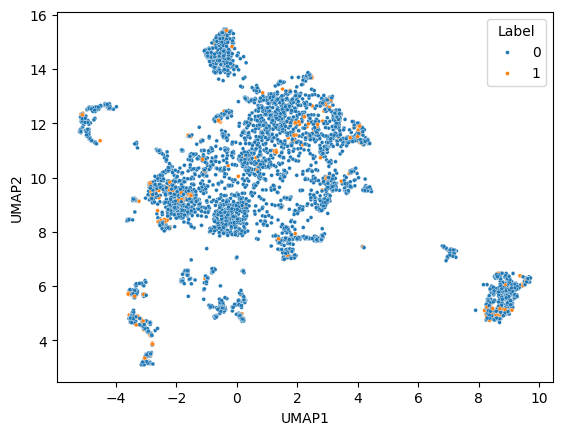

In [18]:
# format as table
embedding = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])

# Create a scatter plot
sns.scatterplot(data=embedding, x='UMAP1', y='UMAP2', hue=train_data['Label'][:5000], s=8)

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

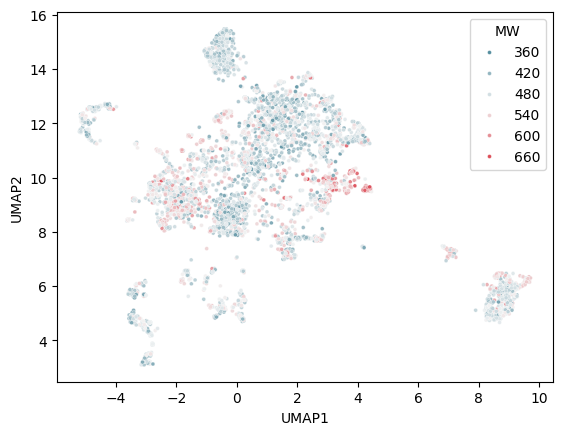

In [19]:
# recolour by molecular weight
sns.scatterplot(data=embedding, x='UMAP1', y='UMAP2', hue=train_data['MW'][:5000], s=8,
                palette = sns.diverging_palette(h_neg=220, h_pos=10, as_cmap=True))

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

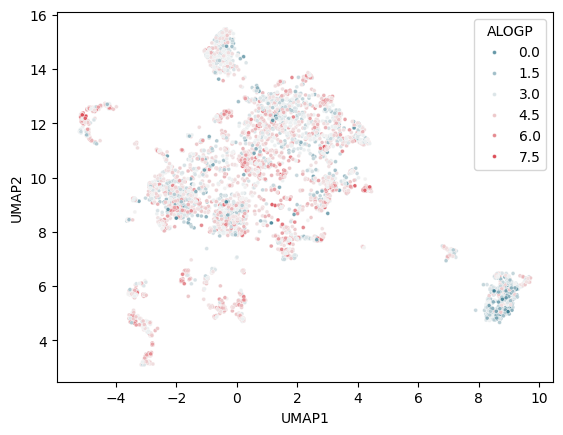

In [20]:
# recolour by ALOGP
sns.scatterplot(data=embedding, x='UMAP1', y='UMAP2', hue=train_data['ALOGP'][:5000], s=8,
                palette = sns.diverging_palette(h_neg=220, h_pos=10, as_cmap=True))

# Build a linear model

Let's build a simple logistic regression model using `sklearn`.

Input: ECFP4 Fingerprints

Output: Label

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [22]:
# First let's convert the ECFP4 strings into lists
X = np.array([list(map(int, s.split(','))) for s in train_data["ECFP4"][:100000]])

In [23]:
y = train_data['Label'][:100000].values  # Binary labels

In [24]:
# Split data into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Train a simple logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy:.2f}')

Model Accuracy: 0.95


# The importance of metrics

The accuracy metric we used above does not take into account class imbalance! A dummy prediction which guesses 0 for everything will also get us a high accuracy...

In [26]:
dummy_pred = np.zeros(y_test.shape)

# Evaluate model performance
accuracy = accuracy_score(y_test, dummy_pred)
print(f'Dummy Accuracy: {accuracy:.2f}')

Dummy Accuracy: 0.92


Other metrics are more useful in imbalanced settings. Specifically for our drug screening, we may be more interested in precision (ie. all our predictions are positive) than recall (ie. we predicted ALL the positives)

In [27]:
import sklearn.metrics
import scipy.stats
import functools
# Let's make some basic functions of the form
# metric(y_true, y_pred).

kendall_tau = lambda x, y: scipy.stats.kendalltau(x, y).statistic

ks = [5, 10, 30]
def precision_at_k(y_true, y_pred, k=1):
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    if y_true.shape != y_pred.shape: raise ValueError
    k = min(k, y_true.shape[0])
    top_k_indices = np.argsort(y_pred)[::-1][:k]
    return np.sum(y_true[top_k_indices]) / k

def mean_average_precision(y_true, y_pred, k=None):
    if y_true.ndim == 1: y_true = y_true.reshape(1, -1)
    if y_pred.ndim == 1: y_pred = y_pred.reshape(1, -1)
    n_queries = y_true.shape[0]
    aps = []
    for i in range(n_queries):
        relevant_indices = np.where(y_true[i] == 1)[0]
        if not relevant_indices.size: aps.append(0.0); continue
        query_y_true = y_true[i]
        query_y_pred = y_pred[i]
        ranked_indices = np.argsort(query_y_pred)[::-1]
        ranked_y_true = query_y_true[ranked_indices]
        precision_sum = 0
        relevant_count = 0
        for rank, true_label in enumerate(ranked_y_true[:k] if k else ranked_y_true, start=1):
            if true_label == 1:
                relevant_count += 1
                precision_sum += relevant_count / rank
        ap = precision_sum / len(relevant_indices) if relevant_indices.size else 0.0
        aps.append(ap)
    return np.mean(aps)

In [28]:
# Collect all our metrics into a dict
metric_dict = {
    'accuracy': sklearn.metrics.accuracy_score,
    'precision': sklearn.metrics.precision_score,
    'recall': sklearn.metrics.recall_score,
    'AUROC':  sklearn.metrics.roc_auc_score,
    'kendalltau': kendall_tau,
    'MeanAveragePrecision' : mean_average_precision,
    'precision@5': functools.partial(precision_at_k, k=5),
    'precision@10': functools.partial(precision_at_k, k=10),
    'precision@30': functools.partial(precision_at_k, k=30),

}
# And call them in a loop!
for metric_name, metric_fn in metric_dict.items():
    print(f'{metric_name:20s}: {metric_fn(y_test, y_pred):.2f}')

accuracy            : 0.95
precision           : 0.73
recall              : 0.49
AUROC               : 0.74
kendalltau          : 0.57
MeanAveragePrecision: 0.44
precision@5         : 0.60
precision@10        : 0.60
precision@30        : 0.67


Whereas the dummy predictor will not be successful in these aspects

In [30]:
for metric_name, metric_fn in metric_dict.items():
    print(f'{metric_name:20s}: {metric_fn(y_test, dummy_pred):.2f}')

accuracy            : 0.92
precision           : 0.00
recall              : 0.00
AUROC               : 0.50
kendalltau          : nan
MeanAveragePrecision: 0.08
precision@5         : 0.00
precision@10        : 0.00
precision@30        : 0.07


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Building confidence (intervals)

When we measure model performance with metrics like precision or MAP, we get a single number. But remember, this number is just an estimate based on the data we have. If we used a slightly different dataset, the metric could change. Confidence intervals acknowledge this uncertainty. Instead of saying "Precision is 0.75," a confidence interval says, "We're 95% confident the true precision is somewhere between 0.70 and 0.80." This range is crucial because it tells us how reliable our metric estimate is. Confidence intervals help us make better comparisons between models, understand the robustness of our results, and make more informed decisions.

One powerful way to estimate these confidence intervals is through bootstrap sampling. Imagine our dataset is a sample from a larger population. Bootstrap cleverly uses our sample to simulate drawing many new datasets. It does this by repeatedly resampling with replacement from our original data. For each simulated dataset, we recalculate our metric. This gives us a distribution of metric values, reflecting how the metric might naturally vary. From this distribution, we can easily determine our confidence interval, for example, by taking the range between the 2.5th and 97.5th percentiles. Bootstrap is incredibly useful because it works with almost any metric, doesn't rely on strong data assumptions, and is computationally straightforward. It provides a practical way to understand the uncertainty in our performance metrics and make more trustworthy evaluations.


In [31]:
def bootstrap_estimates(y_true, y_pred, metric_fn, n_iterations=1000, **metric_kwargs):
    """Bootstrap estimator with replacement for evaluating various metrics."""
    n_samples = y_true.shape[0]
    metric_values = []
    for _ in range(n_iterations):
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        y_true_bootstrap = y_true[indices]
        y_pred_bootstrap = y_pred[indices]
        metric_value = metric_fn(y_true_bootstrap, y_pred_bootstrap, **metric_kwargs)
        metric_values.append(metric_value)
    return np.array(metric_values)

def boostrap_ci(y_true, y_pred, metric_fn, ci=0.95, n_iterations=1000, **metric_kwargs):
    values = bootstrap_estimates(y_true, y_pred, metric_fn, n_iterations=n_iterations, **metric_kwargs)
    lower_percentile = (1 - ci) / 2 * 100
    upper_percentile = 100 - lower_percentile
    lower_bound = np.percentile(values, lower_percentile)
    upper_bound = np.percentile(values, upper_percentile)
    return np.mean(values), lower_bound, upper_bound

In [32]:
for metric_name, metric_fn in metric_dict.items():
    mu, low, high = boostrap_ci(y_test, y_pred, metric_fn)
    print(f'{metric_name:20s}: {mu:.2f} ({low:.2f}, {high:.2f})')

accuracy            : 0.95 (0.94, 0.95)
precision           : 0.73 (0.70, 0.75)
recall              : 0.49 (0.46, 0.51)
AUROC               : 0.74 (0.72, 0.75)
kendalltau          : 0.57 (0.55, 0.59)
MeanAveragePrecision: 0.43 (0.40, 0.46)
precision@5         : 0.72 (0.40, 1.00)
precision@10        : 0.72 (0.40, 1.00)
precision@30        : 0.73 (0.57, 0.90)


**Exercise:** Try to use a GenAI algorithm to plots some nice barplots with confidence intervals

# Your turn

Start thinking about your model. What kinds of data and modelling challenges do you forsee?

* How can we improve generalization to unseen data?
* How can we mitigate class balance challenges?
* Is this dataset representative of the real world? Why or why not?

What other metrics can we use?  
* Keep in mind we need to rank compounds, not just predict binding.